In [1]:
epochs = 10
batch_size = 32
dataset_directory_path = './'
saved_weights_path = './roberta_saved_weights.pt'

In [2]:
!pip install transformers

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

In [4]:
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
training_set = pd.read_csv(dataset_directory_path + "Constraint_English_Training_Set.csv")
training_texts = training_set['tweet']
training_labels = training_set['label'].map({'real': 0, 'fake': 1})

testing_set = pd.read_csv(dataset_directory_path + "english_test_with_labels.csv")
testing_texts = testing_set['tweet']
testing_labels = testing_set['label'].map({'real': 0, 'fake': 1})

validation_set = pd.read_csv(dataset_directory_path + "Constraint_English_Validation_Set.csv")
validation_texts = validation_set['tweet']
validation_labels = validation_set['label'].map({'real': 0, 'fake': 1})

training_set.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [7]:
training_labels.value_counts()

0    3360
1    3060
Name: label, dtype: int64

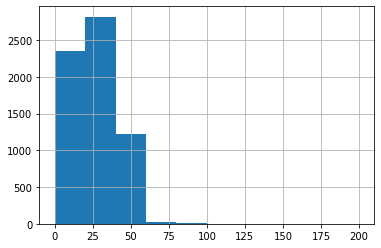

In [8]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in training_texts]

pd.Series(seq_len).hist(range=(0,200))

In [9]:
# For Roberta
from transformers import RobertaTokenizerFast as TokenizerClass
from transformers import RobertaForSequenceClassification as ModelClass
model_name = 'roberta-base'
tokenizer = TokenizerClass.from_pretrained(model_name)
# pt_model = ModelClass.from_pretrained(model_name)
pt_model = ModelClass.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [10]:
training_encodings = tokenizer(training_texts.tolist(), max_length=100, padding='max_length', truncation=True)
validation_encodings = tokenizer(validation_texts.tolist(), max_length=100, padding='max_length', truncation=True)
testing_encodings = tokenizer(testing_texts.tolist(), max_length=100, padding='max_length', truncation=True)

In [11]:
class CovidDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

training_dataset = CovidDataset(training_encodings, training_labels)
validation_dataset = CovidDataset(validation_encodings, validation_labels)
testing_dataset = CovidDataset(testing_encodings, testing_labels)

In [12]:
from torch.utils.data import DataLoader
training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=True)

In [13]:
pt_model.to(device)
pt_model.train()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [14]:
# optimizer
from transformers import AdamW

optimizer = AdamW(pt_model.parameters(), lr = 1e-5) # learning rate

In [15]:
def train(model, dataloader):
  print('Training...')
  model.train()
  total_loss = 0
  t0 = time.time()
  for step, batch in enumerate(dataloader):
    if step % 50 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(dataloader), elapsed))
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = pt_model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs[0]
    total_loss += loss.item()
    loss.backward()
    optimizer.step()
  avg_loss = total_loss / len(dataloader)
  return avg_loss

In [16]:
def evaluate(model, dataloader):
  print('Evaluating...')
  model.eval()
  total_loss = 0
  t0 = time.time()
  for step, batch in enumerate(dataloader):
    if step % 50 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(dataloader), elapsed))
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = pt_model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs[0]
    total_loss += loss.item()
    loss.backward()
    optimizer.step()
  avg_loss = total_loss / len(dataloader)
  return avg_loss

In [17]:
training_losses, validation_losses = [], []
best_validation_loss = float('inf')
for epoch in range(epochs):
  print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
  training_loss = train(pt_model, training_loader)
  validation_loss = evaluate(pt_model, validation_loader)
  if validation_loss < best_validation_loss:
    best_validation_loss = validation_loss
    torch.save(pt_model.state_dict(), saved_weights_path)
  training_losses.append(training_loss)
  validation_losses.append(validation_loss)
  print(f'\nAverage training loss: {training_loss:.3f}')
  print(f'Average validation loss: {validation_loss:.3f}\n')

======== Epoch 1 / 10 ========
Training...
  Batch    50  of    201.    Elapsed: 0:00:26.
  Batch   100  of    201.    Elapsed: 0:00:54.
  Batch   150  of    201.    Elapsed: 0:01:23.
  Batch   200  of    201.    Elapsed: 0:01:51.
Evaluating...
  Batch    50  of     67.    Elapsed: 0:00:27.

Average training loss: 0.281
Average validation loss: 0.097

======== Epoch 2 / 10 ========
Training...
  Batch    50  of    201.    Elapsed: 0:00:28.
  Batch   100  of    201.    Elapsed: 0:00:57.
  Batch   150  of    201.    Elapsed: 0:01:25.
  Batch   200  of    201.    Elapsed: 0:01:53.
Evaluating...
  Batch    50  of     67.    Elapsed: 0:00:28.

Average training loss: 0.069
Average validation loss: 0.032

======== Epoch 3 / 10 ========
Training...
  Batch    50  of    201.    Elapsed: 0:00:28.
  Batch   100  of    201.    Elapsed: 0:00:57.
  Batch   150  of    201.    Elapsed: 0:01:25.
  Batch   200  of    201.    Elapsed: 0:01:53.
Evaluating...
  Batch    50  of     67.    Elapsed: 0:00:27.


In [18]:
import plotly.express as px
f = pd.DataFrame(training_losses)
f.columns=['Loss']
fig = px.line(f, x=f.index, y=f.Loss)
fig.update_layout(title='Training Loss of The Model',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')
fig.show()

In [19]:
f = pd.DataFrame(validation_losses)
f.columns=['Loss']
fig = px.line(f, x=f.index, y=f.Loss)
fig.update_layout(title='Validation Loss of The Model',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')
fig.show()

In [20]:
#load weights of best model
pt_model.load_state_dict(torch.load(saved_weights_path))

<All keys matched successfully>

In [21]:
# get predictions for test data

with torch.no_grad():
  # empty list to save the model predictions
  total_preds, true_labels = [], []

  # iterate over batches
  for step, batch in enumerate(testing_loader):
    # push the batch to gpu
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = pt_model(input_ids, attention_mask=attention_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    total_preds.append(logits)
    label_ids = labels.to('cpu').numpy()
    true_labels.append(label_ids)

In [22]:
total_preds = np.concatenate(total_preds, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

In [23]:
len(total_preds)

2140

In [24]:
len(true_labels)

2140

In [25]:
from sklearn.metrics import classification_report
# model's performance
preds = np.argmax(total_preds, axis = 1)
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1120
           1       0.98      0.98      0.98      1020

    accuracy                           0.98      2140
   macro avg       0.98      0.98      0.98      2140
weighted avg       0.98      0.98      0.98      2140



In [26]:
# confusion matrix
pd.crosstab(true_labels, preds)

col_0,0,1
row_0,,
0,1101,19
1,20,1000
